# Importing Libraries

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Displaying signatures

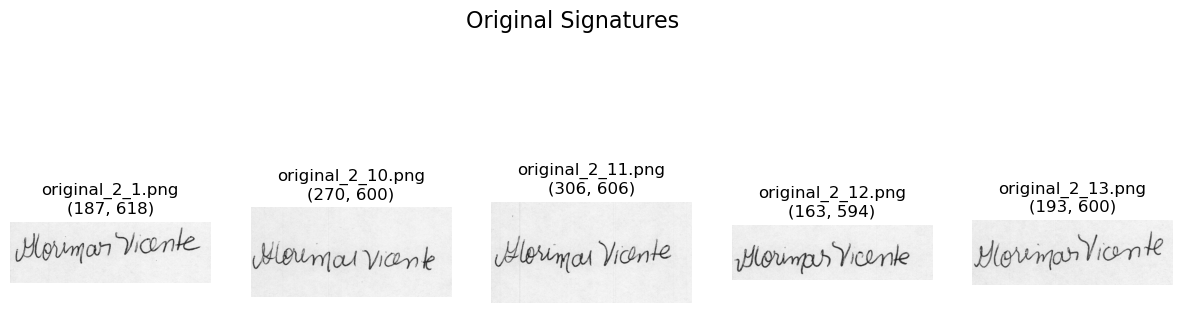

Test Signature Size: (282, 624)


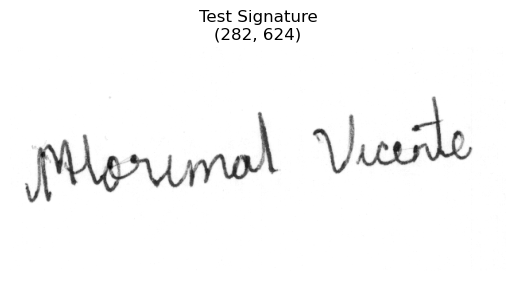

In [8]:
# Path to your dataset
original_signatures_path = "C:/data/dsatm/5th sem/Mini Project/dataset/cedar dataset/trial/original"  # Update this to your folder path
test_signature_path = "C:/data/dsatm/5th sem/Mini Project/dataset/cedar dataset/trial/fake/forgeries_2_2.png"  # Update this to your test image file path

# Helper function to load images and display their sizes
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append((img, filename, img.shape))  # Store image, filename, and size
    return images

# Load original and test signatures
original_signatures = load_images_from_folder(original_signatures_path)
test_signature = cv2.imread(test_signature_path, cv2.IMREAD_GRAYSCALE)

# Display some original signatures and their sizes
def display_images_with_sizes(images, title="Original Signatures", rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for i in range(min(len(images), rows * cols)):
        img, filename, size = images[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{filename}\n{size}")
    fig.suptitle(title, fontsize=16)
    plt.show()

# Show samples and their sizes
display_images_with_sizes(original_signatures, title="Original Signatures")
print(f"Test Signature Size: {test_signature.shape if test_signature is not None else 'Not Loaded'}")
plt.imshow(test_signature, cmap='gray')
plt.title(f"Test Signature\n{test_signature.shape if test_signature is not None else 'N/A'}")
plt.axis("off")
plt.show()


# Pre-processing 

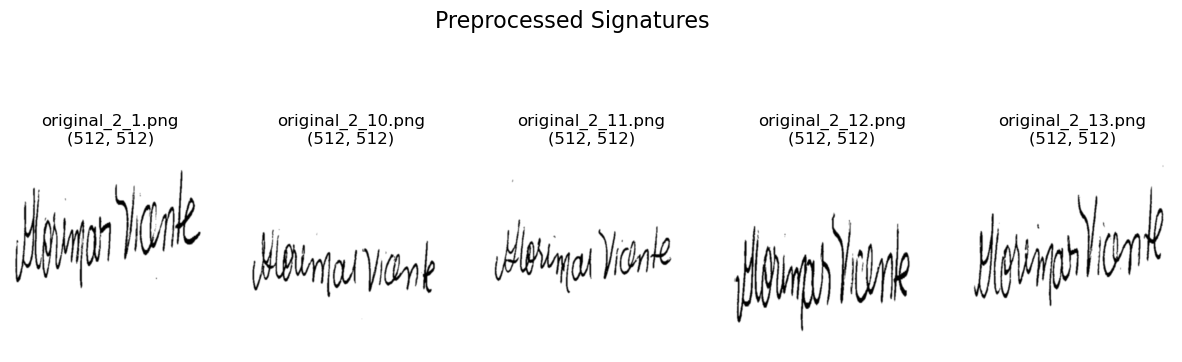

Preprocessed Test Signature Size: (512, 512)


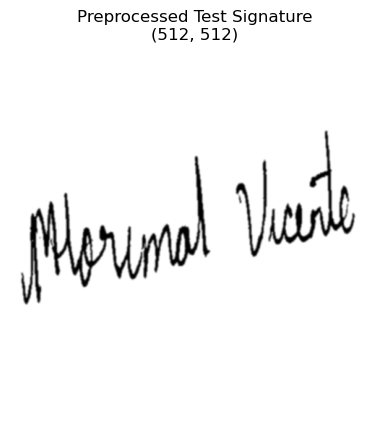

In [9]:
def preprocess_signature(image, resize_dim=(512,512)):
    
    # Convert to grayscale (if not already)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize the image
    image = cv2.resize(image, resize_dim, interpolation=cv2.INTER_AREA)
    
    # Binarize the image using Otsu's thresholding
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply noise reduction (Gaussian blur)
    denoised_image = cv2.GaussianBlur(binary_image, (5, 5), 0)
    
    # Extract the signature region using contours
    contours, _ = cv2.findContours(denoised_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped_image = denoised_image[y:y+h, x:x+w]
        
        # Resize cropped region back to target dimensions
        cropped_image = cv2.resize(cropped_image, resize_dim, interpolation=cv2.INTER_AREA)
    else:
        # If no contours found, use the whole image
        cropped_image = denoised_image
    
    return cropped_image

# Preprocess dataset
def preprocess_dataset(images):
    preprocessed_images = []
    for img, filename, original_size in images:
        preprocessed_img = preprocess_signature(img)
        resize = preprocessed_img.shape
        preprocessed_images.append((preprocessed_img, filename, resize))
    return preprocessed_images

preprocessed_original_signatures = preprocess_dataset(original_signatures)
preprocessed_test_signature = preprocess_signature(test_signature) 

# Display some preprocessed signatures and their sizes
def display_images_with_sizes(images, title="Preprocessed Signatures", rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for i in range(min(len(images), rows * cols)):
        img, filename, size = images[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{filename}\n{size}")
    fig.suptitle(title, fontsize=16)
    plt.show()

# Show samples and their sizes
display_images_with_sizes(preprocessed_original_signatures, title="Preprocessed Signatures")
print(f"Preprocessed Test Signature Size: {preprocessed_test_signature.shape if preprocessed_test_signature is not None else 'Not Loaded'}")
plt.imshow(preprocessed_test_signature, cmap='gray')
plt.title(f"Preprocessed Test Signature\n{preprocessed_test_signature.shape if preprocessed_test_signature is not None else 'N/A'}")
plt.axis("off")
plt.show()


# Segmentation

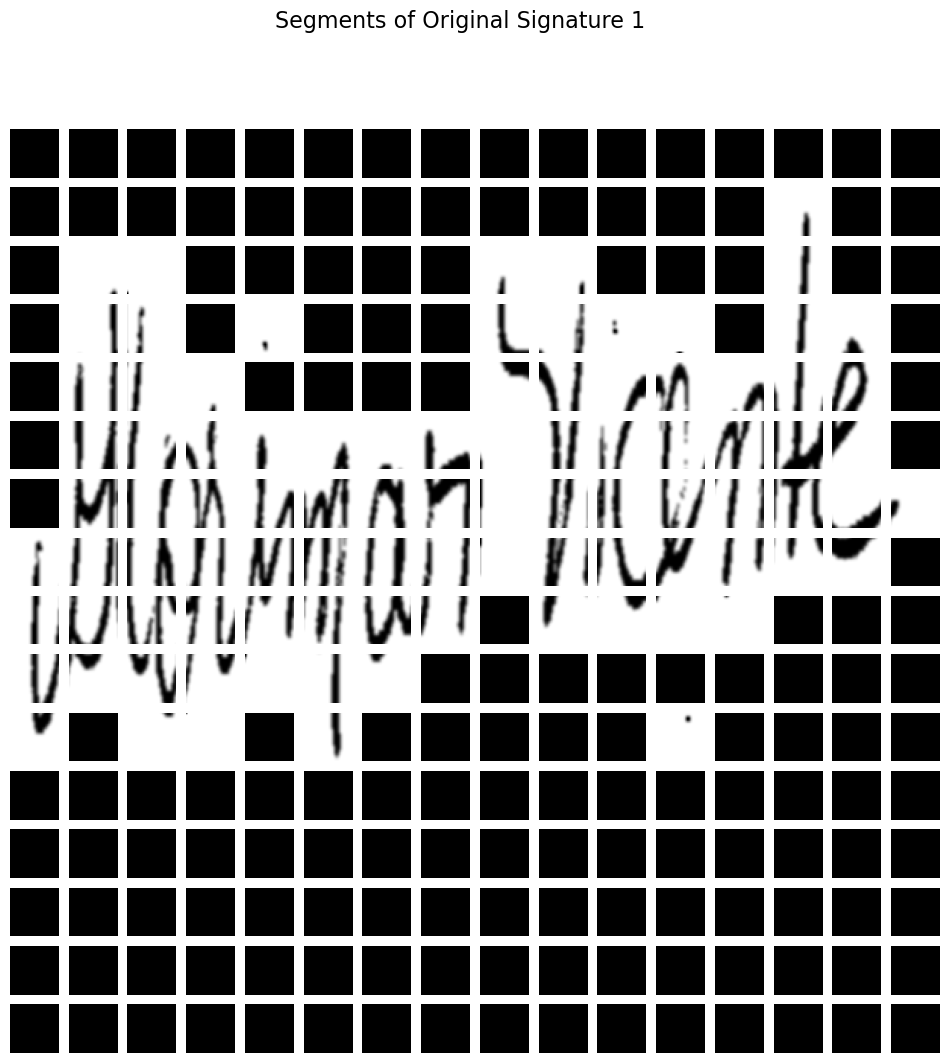

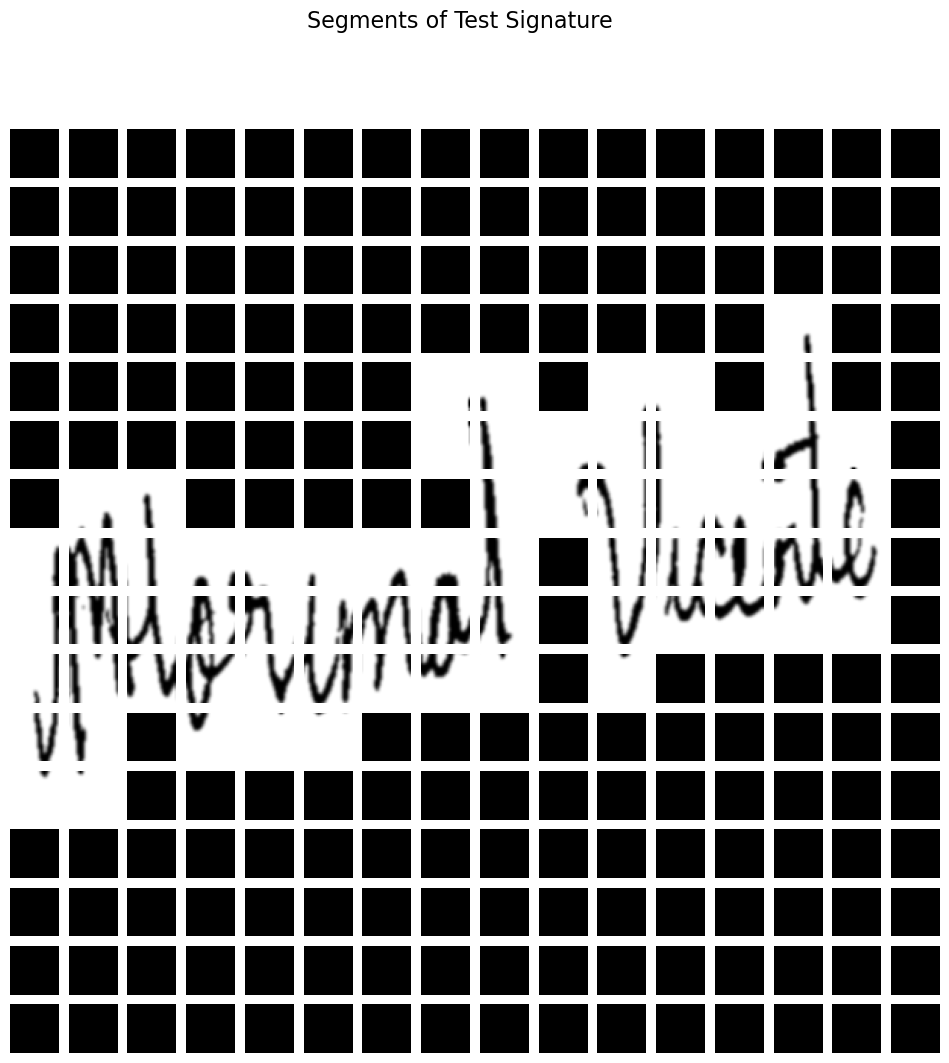

In [10]:
grid_size=(16, 16)
def segment_image(image, grid_size=grid_size):
    """
    Segment the image into a 16x16 grid for more detailed comparison.
    
    Args:
        image (numpy array): Preprocessed image.
        grid_size (tuple): Number of rows and columns for the grid (64x64).
    
    Returns:
        List of segments.
    """
    h, w = image.shape
    rows, cols = grid_size
    segment_height = h // rows
    segment_width = w // cols
    
    segments = []
    for r in range(rows):
        for c in range(cols):
            segment = image[r * segment_height:(r + 1) * segment_height, c * segment_width:(c + 1) * segment_width]
            segments.append(segment)
    return segments

def segment_dataset(images):
    segmented_images = []
    for img, filename, original_size in images:
        segmented_img = segment_image(img, grid_size=grid_size)
        segmented_images.append(segmented_img)
    return segmented_images

# Segment all preprocessed original signatures with 64x64 grid
segmented_signatures_16x16 = segment_dataset(preprocessed_original_signatures)

# Segment the preprocessed test signature with 64x64 grid
segmented_test_signature_16x16 = segment_image(preprocessed_test_signature, grid_size=grid_size)

# Display segments from the first preprocessed original signature
def display_segments(segments, grid_size=grid_size, title="Segments"):
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(segments[i], cmap='gray')
        ax.axis('off')
    fig.suptitle(title, fontsize=16)
    plt.show()

# Show segments for the first original signature and the test signature
display_segments(segmented_signatures_16x16[0], grid_size=grid_size, title="Segments of Original Signature 1")
display_segments(segmented_test_signature_16x16, grid_size=grid_size, title="Segments of Test Signature")


# Comparison using MSE, SSIM and Template Matching scores

## original comparison

### 16x16

In [11]:
# Function to calculate MSE between two segments
def calculate_mse(segment1, segment2):
    return np.mean((segment1.astype("float") - segment2.astype("float")) ** 2)

# Function to calculate SSIM between two segments
from skimage.metrics import structural_similarity as compare_ssim

def calculate_ssim(segment1, segment2):
    # Ensure segments meet the win_size requirement
    smallest_dim = min(segment1.shape[0], segment1.shape[1])
    win_size = min(7, smallest_dim) if smallest_dim >= 7 else smallest_dim
    if win_size % 2 == 0:  # Ensure win_size is odd
        win_size -= 1

    score, _ = compare_ssim(segment1, segment2, full=True, win_size=win_size)
    return score

# Template Matching Function
def calculate_template_match(segment1, segment2):
    """
    Calculate the normalized cross-correlation score using template matching.
    Args:
        segment1 (numpy array): Segment from original signature.
        segment2 (numpy array): Segment from test signature.
    Returns:
        float: Template matching score.
    """
    # Ensure the template and image are compatible in size
    if segment1.shape != segment2.shape:
        segment2 = cv2.resize(segment2, (segment1.shape[1], segment1.shape[0]))

    # Apply template matching
    match_result = cv2.matchTemplate(segment1, segment2, cv2.TM_CCOEFF_NORMED)
    return np.max(match_result)

def compare_signature(original_segments_list, test_segments, weights=None, skip_identical=True):
    """
    Compare test signature segments with original signature segments using 
    MSE, SSIM, and Template Matching. Skip comparisons if original and test segments are identical.

    Args:
        original_segments_list (list): List of segments for each original signature.
        test_segments (list): Segments of the test signature.
        weights (list or None): Weights for individual segments.
        skip_identical (bool): Whether to skip comparisons of identical segments.

    Returns:
        list of dicts: Contains scores for MSE, SSIM, and Template Matching.
    """
    results = []
    
    for idx, original_segments in enumerate(original_segments_list):
        # Skip identical comparisons if requested
        if skip_identical and original_segments is test_segments:
            continue
        
        scores = {"mse": [], "ssim": [], "template": []}
        
        for i in range(len(original_segments)):
            # Calculate MSE
            mse_score = calculate_mse(original_segments[i], test_segments[i])
            scores["mse"].append(1 / (1 + mse_score))  # Normalize MSE
            
            # Calculate SSIM
            ssim_score = calculate_ssim(original_segments[i], test_segments[i])
            scores["ssim"].append(ssim_score)
            
            # Calculate Template Matching
            template_score = calculate_template_match(original_segments[i], test_segments[i])
            scores["template"].append(template_score)
        
        # Aggregate scores
        mse_avg = np.average(scores["mse"], weights=weights)
        ssim_avg = np.average(scores["ssim"], weights=weights)
        template_avg = np.average(scores["template"], weights=weights)
        
        # Append final scores for this signature
        results.append({"mse_avg": mse_avg, "ssim_avg": ssim_avg, "template_avg": template_avg})
    
    return results

mse_scores, ssim_scores, temp_scores=[],[],[]

for i in range(len(segmented_signatures_16x16)):
    print(f"Comparison with Original signature {i+1}")
    # Example Usage
    comparison_results = compare_signature(
        original_segments_list=segmented_signatures_16x16,
        test_segments=segmented_signatures_16x16[i],  # Change this to another set for meaningful comparisons
        weights=None,
        skip_identical=True
    )

    # Display Results
    for idx, result in enumerate(comparison_results):
        print(
            f"Original Signature {idx + 1}: "
            f"MSE Score = {result['mse_avg']:.4f}, "
            f"SSIM Score = {result['ssim_avg']:.4f}, "
            f"Template Match Score = {result['template_avg']:.4f}"
        )

    # Calculating Average
    mse = np.mean([result['mse_avg'] for result in comparison_results])
    ssim = np.mean([result['ssim_avg'] for result in comparison_results])
    temp = np.mean([result['template_avg'] for result in comparison_results])
    print(f"Average MSE : {mse}\nAverage SSIM : {ssim}\nAverage TM : {temp}\n")

    mse_scores.append(mse)
    ssim_scores.append(ssim)
    temp_scores.append(temp)

mse_org_16x16 = np.mean([mse for mse in mse_scores])
ssim_org_16x16 = np.mean([ssim for ssim in ssim_scores])
temp_org_16x16 = np.mean([temp for temp in temp_scores])
print(f"MSE Scores : {mse_scores}\nSSIM Scores : {ssim_scores}\nTM Scores : {temp_scores}\n\nMSE Score : {mse_org_16x16}\nSSIM Score : {ssim_org_16x16}\nTM Score : {temp_org_16x16}")

Comparison with Original signature 1
Original Signature 1: MSE Score = 0.5308, SSIM Score = 0.7354, Template Match Score = 0.6465
Original Signature 2: MSE Score = 0.5832, SSIM Score = 0.7600, Template Match Score = 0.6488
Original Signature 3: MSE Score = 0.4608, SSIM Score = 0.6737, Template Match Score = 0.6524
Original Signature 4: MSE Score = 0.5345, SSIM Score = 0.7260, Template Match Score = 0.6555
Original Signature 5: MSE Score = 0.4248, SSIM Score = 0.6599, Template Match Score = 0.6618
Original Signature 6: MSE Score = 0.5675, SSIM Score = 0.7434, Template Match Score = 0.6386
Original Signature 7: MSE Score = 0.5163, SSIM Score = 0.6853, Template Match Score = 0.6264
Original Signature 8: MSE Score = 0.5037, SSIM Score = 0.7106, Template Match Score = 0.6432
Original Signature 9: MSE Score = 0.6146, SSIM Score = 0.7582, Template Match Score = 0.6415
Original Signature 10: MSE Score = 0.4794, SSIM Score = 0.6821, Template Match Score = 0.6346
Original Signature 11: MSE Score

### Fake comparison

### 16x16

In [12]:
# Function to calculate MSE between two segments
def calculate_mse(segment1, segment2):
    return np.mean((segment1.astype("float") - segment2.astype("float")) ** 2)

# Function to calculate SSIM between two segments
from skimage.metrics import structural_similarity as compare_ssim

def calculate_ssim(segment1, segment2):
    # Ensure segments meet the win_size requirement
    smallest_dim = min(segment1.shape[0], segment1.shape[1])
    win_size = min(7, smallest_dim) if smallest_dim >= 7 else smallest_dim
    if win_size % 2 == 0:  # Ensure win_size is odd
        win_size -= 1

    score, _ = compare_ssim(segment1, segment2, full=True, win_size=win_size)
    return score

# Template Matching Function
def calculate_template_match(segment1, segment2):
    """
    Calculate the normalized cross-correlation score using template matching.
    Args:
        segment1 (numpy array): Segment from original signature.
        segment2 (numpy array): Segment from test signature.
    Returns:
        float: Template matching score.
    """
    # Ensure the template and image are compatible in size
    if segment1.shape != segment2.shape:
        segment2 = cv2.resize(segment2, (segment1.shape[1], segment1.shape[0]))

    # Apply template matching
    match_result = cv2.matchTemplate(segment1, segment2, cv2.TM_CCOEFF_NORMED)
    return np.max(match_result)

# Enhanced Comparison Function
def compare_signatures_with_template(original_segments_list, test_segments, weights=None):
    """
    Compare test signature segments with original signature segments using 
    MSE, SSIM, and Template Matching.
    
    Args:
        original_segments_list (list): List of segments for each original signature.
        test_segments (list): Segments of the test signature.
        weights (list or None): Weights for individual segments.
    
    Returns:
        list of dicts: Contains scores for MSE, SSIM, and Template Matching.
    """
    results = []
    
    for original_segments in original_segments_list:
        scores = {"mse": [], "ssim": [], "template": []}
        
        for i in range(len(original_segments)):
            # Calculate MSE
            mse_score = calculate_mse(original_segments[i], test_segments[i])
            scores["mse"].append(1 / (1 + mse_score))  # Normalize MSE
            
            # Calculate SSIM
            ssim_score = calculate_ssim(original_segments[i], test_segments[i])
            scores["ssim"].append(ssim_score)
            
            # Calculate Template Matching
            template_score = calculate_template_match(original_segments[i], test_segments[i])
            scores["template"].append(template_score)
        
        # Aggregate scores
        mse_avg = np.average(scores["mse"], weights=weights)
        ssim_avg = np.average(scores["ssim"], weights=weights)
        template_avg = np.average(scores["template"], weights=weights)
        
        # Append final scores for this signature
        results.append({"mse_avg": mse_avg, "ssim_avg": ssim_avg, "template_avg": template_avg})
    
    return results

# Compute similarity scores for all original signatures
comparison_results = compare_signatures_with_template(segmented_signatures_16x16, segmented_test_signature_16x16, weights=None)

# Display Results
for idx, result in enumerate(comparison_results):
    
    print(
        f"Original Signature {idx + 1}: "
        f"MSE Score = {result['mse_avg']:.4f}, "
        f"SSIM Score = {result['ssim_avg']:.4f}, "
        f"Template Match Score = {result['template_avg']:.4f}"
    )

# Calculating Average
mse_16x16 = np.mean([result['mse_avg'] for result in comparison_results])
ssim_16x16 = np.mean([result['ssim_avg'] for result in comparison_results])
temp_16x16 = np.mean([result['template_avg'] for result in comparison_results])
print(f"MSE score: {mse_16x16}\nSSIM score: {ssim_16x16}\nTM score: {temp_16x16}")

Original Signature 1: MSE Score = 0.6004, SSIM Score = 0.7607, Template Match Score = 0.7231
Original Signature 2: MSE Score = 0.6385, SSIM Score = 0.8193, Template Match Score = 0.7435
Original Signature 3: MSE Score = 0.6679, SSIM Score = 0.8325, Template Match Score = 0.7286
Original Signature 4: MSE Score = 0.5649, SSIM Score = 0.7593, Template Match Score = 0.7521
Original Signature 5: MSE Score = 0.5967, SSIM Score = 0.7789, Template Match Score = 0.7292
Original Signature 6: MSE Score = 0.4889, SSIM Score = 0.7231, Template Match Score = 0.7351
Original Signature 7: MSE Score = 0.5967, SSIM Score = 0.7828, Template Match Score = 0.7383
Original Signature 8: MSE Score = 0.5633, SSIM Score = 0.7370, Template Match Score = 0.7378
Original Signature 9: MSE Score = 0.5880, SSIM Score = 0.7803, Template Match Score = 0.7332
Original Signature 10: MSE Score = 0.6327, SSIM Score = 0.7857, Template Match Score = 0.7451
Original Signature 11: MSE Score = 0.5908, SSIM Score = 0.7743, Templ